# Nonparametric inference changes in spm1d v0.4.50

(2025-06-03)

A [recent discussion](https://github.com/0todd0000/spm1d/issues/307) in the **spm1d** support forum uncovered a bug in nonparametric inference. (Thank you very much to Jeremy for discovering this bug!!)

The bug affects both the Python and MATLAB versions of **spm1d** for all versions prior to v0.4.50.

The bug affects the following procedures:

- `spm1d.stats.nonparam.ttest`
- `spm1d.stats.nonparam.ttest_paired`
- `spm1d.stats.nonparam.ttest2`
- `spm1d.stats.nonparam.regress`
- `spm1d.stats.nonparam.ci_onesample`
- `spm1d.stats.nonparam.ci_pairedsample`
- `spm1d.stats.nonparam.ci_twosample`


**Note**: Although the bug affects several procedures, its effects are expected to be large only for a relatively specific scenario involving all of the following simultaneously:

- a small total sample size, less than about $N$=10
- two-tailed inference, and
- large effects in both the positive and negative direction


Below is a description of the bug and a demonstration of its resolution in spm1d v0.4.50.

<br>
<br>

___

## Preliminaries

Ensure that the spm1d source code is on your path:

In [1]:
addpath( genpath('/Users/todd/GitHub/spm1dmatlab/') )

Before starting verify that you have **spm1d** version 0.4.50 or later.

The `spm1d.version()` command may generate an error for older versions of **spm1d**.

In [2]:
disp( spm1d.version() )

0.4.50


Note that the `spm1d.stats.nonparam` subpackage has been rewritten. If you wish to replicate previous versions' results please use the `spm1d.stats.nonparam_old` package which retains the original code.

<br>
<br>

___

## Dataset

Let's load an example dataset that demonstrates the problem:

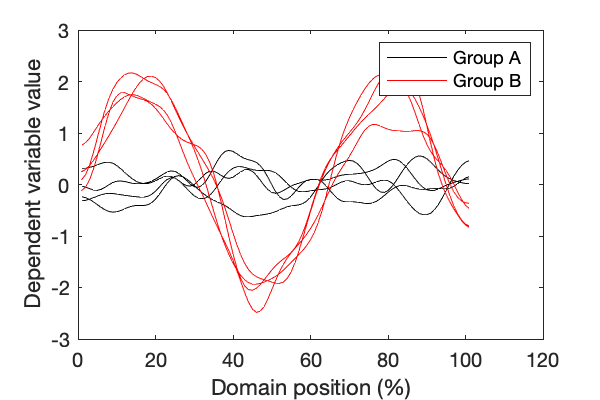

In [3]:
dataset = spm1d.data.uv1d.t2.SmallSampleLargePosNegEffects();
[y0,y1] = deal(dataset.YA, dataset.YB);

figure('Position', [10 10 300 200])
h0 = plot( y0', color='k' );
hold on
h1 = plot( y1', color='r' );
xlabel('Domain position (%)')
ylabel('Dependent variable value')
legend([h0(1) h1(1)], 'Group A', 'Group B');

These data are simulated as per the [forum example](https://github.com/0todd0000/spm1d/issues/307#issuecomment-2922313177) provided by Dr. Jeremy Eekhoff. This dataset meets two of the aforementioned bug criteria:

- a small total sample size, less than about $N$=10
- large effects in both the positive and negative direction

The third criterion (two-tailed inference) is demonstrated below.

This dataset can be replicated in Python using the attached `gen_data` function with `n=4`. The `gen_data` function is defined for arbitrary `n` so that effects of `n` can be subsequently considered.

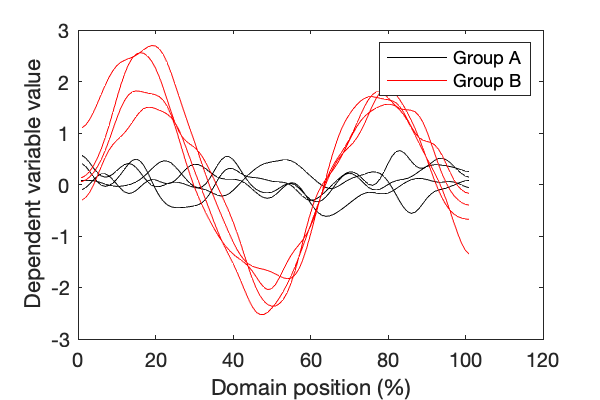

In [4]:
rng(4)
[y0,y1] = gen_data(4);

figure('Position', [10 10 300 200])
h0 = plot( y0', color='k' );
hold on
h1 = plot( y1', color='r' );
xlabel('Domain position (%)')
ylabel('Dependent variable value')
legend([h0(1) h1(1)], 'Group A', 'Group B');


<br>
<br>

___

## Bug description

In **spm1d** versions prior to v0.4.50, nonparametric inference yielded an odd critical threshold for this scenario. The critical threshold "zstar (nonparam old)" in the figure below is substantially different from both the parametric threshold and the new nonparametric threshold.

zstar (param):         5.91801
zstar (nonparam):      5.14050
zstar (nonparam old):  8.78362


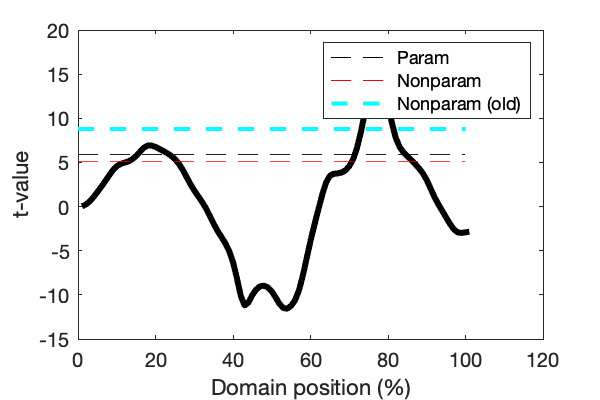

In [5]:

two_tailed = true;
niter = -1;

t     = spm1d.stats.ttest2(y1, y0).inference(0.05, 'two_tailed', two_tailed);
tn    = spm1d.stats.nonparam.ttest2(y1, y0).inference(0.05, 'iterations', niter, 'two_tailed', two_tailed);
tno   = spm1d.stats.nonparam_old.ttest2(y1, y0).inference(0.05, 'iterations', niter, 'two_tailed', two_tailed);

disp( sprintf( 'zstar (param):         %.5f', t.zstar) )
disp( sprintf( 'zstar (nonparam):      %.5f', tn.zstar) )
disp( sprintf( 'zstar (nonparam old):  %.5f', tno.zstar) )


figure('Position', [10 10 300 200])
plot(t.z, 'k', 'linewidth', 3);
hold on
Q = numel(t.z);
h0 = plot([0 Q-1], t.zstar*[1 1], 'k--');
h1 = plot([0 Q-1], tn.zstar*[1 1], 'r--');
h2 = plot([0 Q-1], tno.zstar*[1 1], 'c--', 'linewidth', 2);
xlabel('Domain position (%)')
ylabel('t-value')
legend([h0 h1 h2], 'Param', 'Nonparam', 'Nonparam (old)');



The attached `examine_bug` function assembles the code from the cell above to allow us to more closely focus on the relevant parameters: the data `y0` and `y1`, and the inference tailedness: `two_tailed`.

zstar (param):         5.91801
zstar (nonparam):      5.14050
zstar (nonparam old):  8.78362


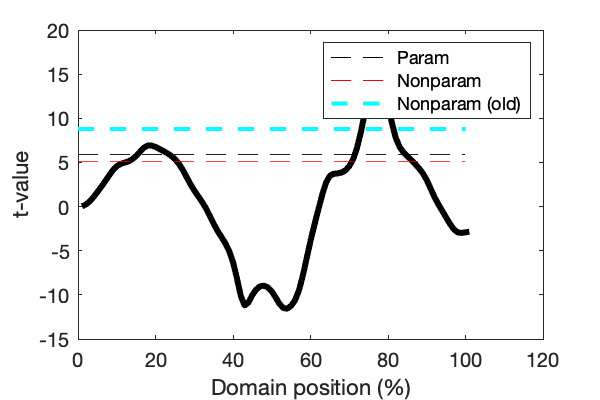

In [6]:
examine_bug(y0, y1, true)

Note that the bug persists when the order of the input arguments `y1` and `y0` is reversed:

zstar (param):         5.91801
zstar (nonparam):      4.27920
zstar (nonparam old):  8.78362


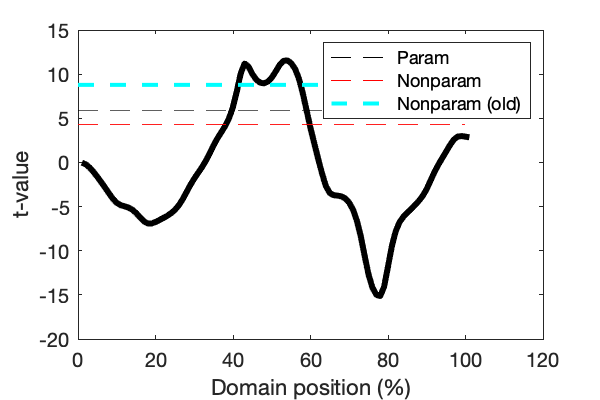

In [7]:
examine_bug(y1, y0, true)

However the bug disappears for one-tailed inference: 

zstar (param):         4.99737
zstar (nonparam):      4.27920
zstar (nonparam old):  4.27920


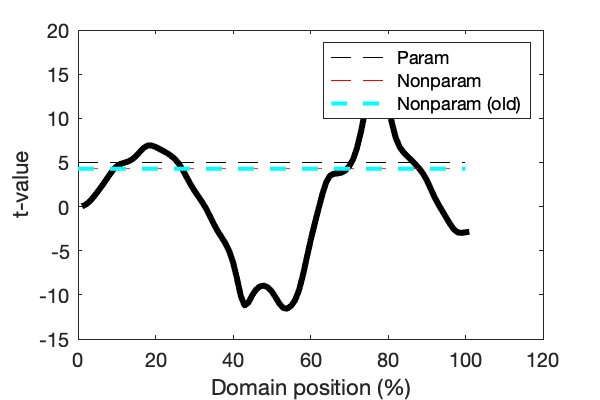

In [8]:
examine_bug(y0, y1, false)

As described in the [spm1d forum](https://github.com/0todd0000/spm1d/issues/307) this bug was caused by inadequate consideration of both large negative AND large postive effects in a single dataset. Specifically, when conducting two-tailed inference, the maximum **absolute** effect in permutation should be used as the basis for inference. The previous **spm1d** code failed to do this.

There are two reasons that this bug was not discovered during previous **spm1d** development:

1. During previous development only larger sample sizes were considered (`n>=6`)
1. The bug disappears for larger sample sizes (see cell below)


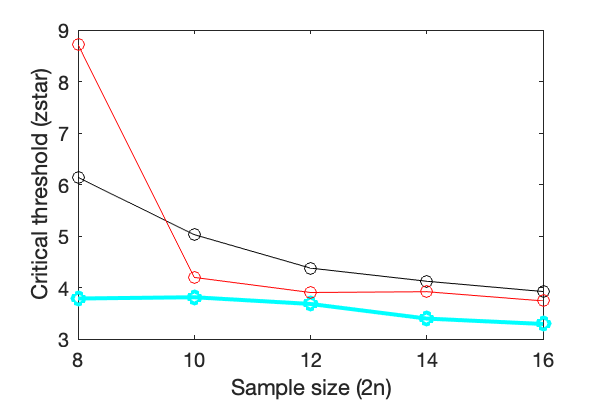

In [9]:
rng(1)
two_tailed = true;
niter      = -1;
ns         = [4, 5, 6, 7, 8];
zc         = zeros(1, 5);  % critical threshold for parametric inference
zcn        = zeros(1, 5);  % critical threshold for nonparametric inference -- version 0.4.50
zco        = zeros(1, 5);  % critical threshold for parametric inference -- prior to version 0.4.50

for i = 1:numel(ns)
    [y0,y1] = gen_data( ns(i) );
    t       = spm1d.stats.ttest2(y1, y0).inference(0.05, 'two_tailed', two_tailed);
    tn      = spm1d.stats.nonparam.ttest2(y1, y0).inference(0.05, 'iterations', niter, 'two_tailed', two_tailed, 'force_iterations', true);
    tno     = spm1d.stats.nonparam_old.ttest2(y1, y0).inference(0.05, 'iterations', niter, 'two_tailed', two_tailed, 'force_iterations', true);
    zc(i)   = t.zstar;
    zcn(i)  = tn.zstar;
    zcno(i) = tno.zstar;
end


figure('Position', [10 10 300 200])
h0 = plot(2*ns, zc, 'ko-');
hold on
h1 = plot(2*ns, zcn, 'co-', 'linewidth', 2);
h2 = plot(2*ns, zcno, 'ro-');
xlabel('Sample size (2n)')
ylabel('Critical threshold (zstar)')



<br>
<br>

___

## Other scenarios

This bug is only expected to affect scenarios that meet the three criteria specified at the beginning of this notebook. For example, the bug does not appear for the  `SimulatedTwoLocalMax` dataset (see below) because there are NOT large effects in both positive and negative directions.

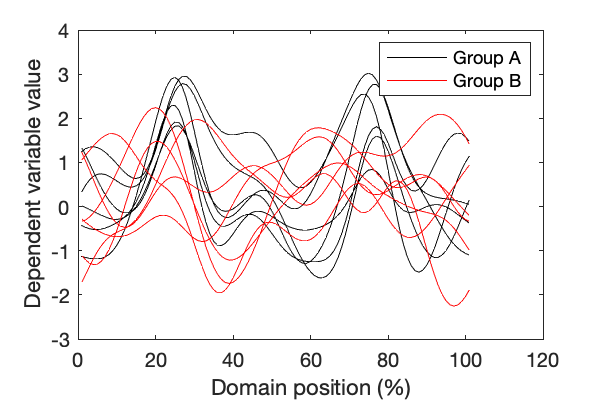

zstar (param):         4.06590
zstar (nonparam):      3.38085
zstar (nonparam old):  4.14080


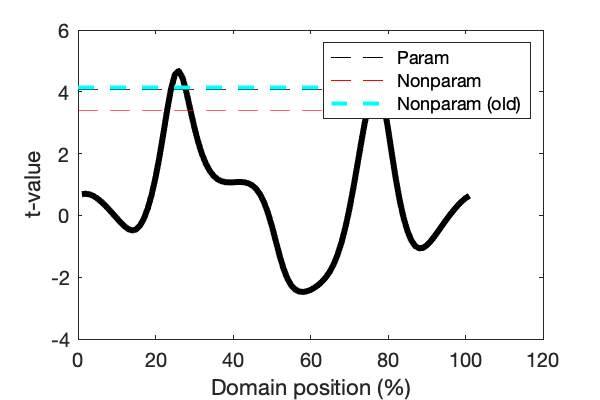

In [10]:
dataset = spm1d.data.uv1d.t2.SimulatedTwoLocalMax();
[y0,y1] = deal(dataset.YA, dataset.YB);

figure('Position', [10 10 300 200])
h0 = plot( y0', color='k' );
hold on
h1 = plot( y1', color='r' );
xlabel('Domain position (%)')
ylabel('Dependent variable value')
legend([h0(1) h1(1)], 'Group A', 'Group B');


examine_bug(y1, y0, true)


The bug is absent even when reducing sample size to an extremely small value of `n=3`.

zstar (param):         8.18421
zstar (nonparam):      5.57132
zstar (nonparam old):  5.63180


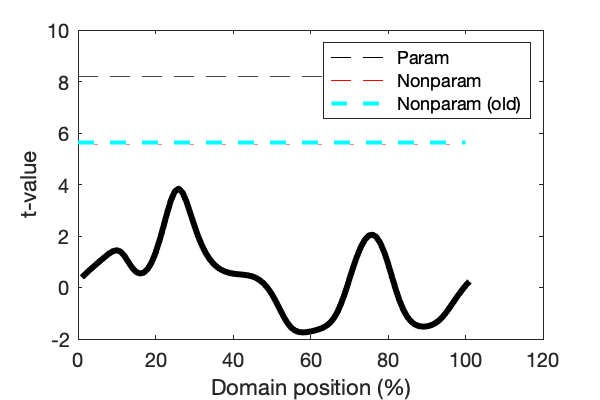

In [11]:

examine_bug(y1(1:3,:), y0(1:3,:), true)


## Summary

spm1d versions prior to v0.4.50 are subject to the nonparametric inference bug described above.

The bug is expected to only affect a relatively specific scenario involving all three of the following criteria:

- a small total sample size, less than about $N$=10
- two-tailed inference, and
- large effects in both the positive and negative direction

In general the **spm1d** developers recommend NOT analyzing datasets with a total sample size less than $N$=10 because all statistical inference procedures (parametric and nonparametric) become problematic for very small sample sizes.


If you discover any additional scenarios that may be relevant, or if you discover any unrelated bugs, please post them to the [spm1d forum](https://github.com/0todd0000/spm1d/issues).